In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout, Concatenate
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Load text data
text_data_path = 'F:/MS Thesis/RND/BanglaText.csv'
df_text = pd.read_csv(text_data_path)

# Encode emotion labels
label_encoder = LabelEncoder()
df_text['Encoded_Emotion'] = label_encoder.fit_transform(df_text['Emotion'])
y_text = df_text['Encoded_Emotion']

# Tokenization and Padding for text data
MAX_VOCAB_SIZE = 20000
MAX_SEQ_LEN = 100

text_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
text_tokenizer.fit_on_texts(df_text['Cleaned_Text'])
X_text = text_tokenizer.texts_to_sequences(df_text['Cleaned_Text'])
X_text = pad_sequences(X_text, maxlen=MAX_SEQ_LEN)

# Split text data
X_text_train, X_text_temp, y_text_train, y_text_temp = train_test_split(X_text, y_text, test_size=0.2, random_state=42, stratify=y_text)
X_text_val, X_text_test, y_text_val, y_text_test = train_test_split(X_text_temp, y_text_temp, test_size=0.5, random_state=42, stratify=y_text_temp)

In [5]:
# Load voice features and labels
voice_features_path = 'F:/MS Thesis/Research/Data/features.npy'
voice_labels_path = 'F:/MS Thesis/Research/Data/labels.npy'
features_voice = np.load(voice_features_path)
labels_voice = np.load(voice_labels_path)

# Encode voice labels
labels_voice_encoded = label_encoder.transform(labels_voice)

# Split voice data
X_voice_train, X_voice_temp, y_voice_train, y_voice_temp = train_test_split(
    features_voice, labels_voice_encoded, test_size=0.2, random_state=42, stratify=labels_voice_encoded
)
X_voice_val, X_voice_test, y_voice_val, y_voice_test = train_test_split(
    X_voice_temp, y_voice_temp, test_size=0.5, random_state=42, stratify=y_voice_temp
)

In [6]:
# Create Bi-LSTM model for text
input_text = Input(shape=(MAX_SEQ_LEN,))
embedding = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_length=MAX_SEQ_LEN)(input_text)
bilstm = Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.5))(embedding)
dense_text = Dense(64, activation='relu')(bilstm)

text_model = Model(inputs=input_text, outputs=dense_text)

E:\python\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [7]:
# Create XGBoost model for voice
voice_dtrain = xgb.DMatrix(X_voice_train, label=y_voice_train)
voice_dval = xgb.DMatrix(X_voice_val, label=y_voice_val)
voice_dtest = xgb.DMatrix(X_voice_test, label=y_voice_test)

xgb_params = {
    'objective': 'multi:softmax',
    'num_class': len(label_encoder.classes_),
    'eval_metric': 'mlogloss',
    'max_depth': 6,
    'learning_rate': 0.1,
    'colsample_bytree': 0.7,
    'subsample': 0.8
}

voice_model = xgb.train(
    params=xgb_params,
    dtrain=voice_dtrain,
    num_boost_round=100
)

# Extract voice embeddings (features from XGBoost predictions)
voice_train_embeddings = voice_model.predict(voice_dtrain)
voice_val_embeddings = voice_model.predict(voice_dval)
voice_test_embeddings = voice_model.predict(voice_dtest)


In [9]:
# Voice embeddings for training, validation, and test sets
voice_train_embeddings = np.expand_dims(voice_train_embeddings, axis=1)  # Shape: (batch_size, 1)
voice_val_embeddings = np.expand_dims(voice_val_embeddings, axis=1)      # Shape: (batch_size, 1)
voice_test_embeddings = np.expand_dims(voice_test_embeddings, axis=1)    # Shape: (batch_size, 1)


In [10]:
from tensorflow.keras.layers import Input, Dense, Concatenate

# Text input (Bi-LSTM embeddings)
text_input = Input(shape=(MAX_SEQ_LEN,), name='Text_Input')
text_embedding = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_length=MAX_SEQ_LEN)(text_input)
text_bilstm = Bidirectional(LSTM(128, dropout=0.5, return_sequences=False))(text_embedding)

# Voice input (XGBoost embeddings)
voice_input = Input(shape=(1,), name='Voice_Input')  # Fix shape to include features

# Concatenate text and voice features
fusion = Concatenate()([text_bilstm, voice_input])

# Dense layers for fusion
fusion_dense = Dense(64, activation='relu')(fusion)
fusion_dropout = Dropout(0.5)(fusion_dense)
output = Dense(6, activation='softmax', name='Output')(fusion_dropout)  # 6 emotions

# Compile model
early_fusion_model = tf.keras.Model(inputs=[text_input, voice_input], outputs=output)
early_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train the model
history_early = early_fusion_model.fit(
    [X_text_train, voice_train_embeddings], y_text_train,
    validation_data=([X_text_val, voice_val_embeddings], y_text_val),
    epochs=30,
    batch_size=32
)


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 123s 405ms/step - accuracy: 0.3495 - loss: 1.6163 - val_accuracy: 0.6133 - val_loss: 1.3760
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 63s 289ms/step - accuracy: 0.6371 - loss: 1.0502 - val_accuracy: 0.6550 - val_loss: 1.1874
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 48s 318ms/step - accuracy: 0.8173 - loss: 0.6115 - val_accuracy: 0.6567 - val_loss: 1.1324
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 53s 348ms/step - accuracy: 0.8882 - loss: 0.3963 - val_accuracy: 0.6517 - val_loss: 1.2579
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 272ms/step - accuracy: 0.9450 - loss: 0.2183 - val_accuracy: 0.6667 - val_loss: 1.3463
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 43s 286ms/step - accuracy: 0.9639 - loss: 0.1551 - val_accuracy: 0.6500 - val_loss: 1.3546
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 260ms/step - accuracy: 0.9736 - loss: 0.1176 - val_accuracy: 0.6617 - val_loss: 1.4158
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 216ms/step - accuracy: 0.9756 - loss: 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

Early Fusion - Classification Report:

              precision    recall  f1-score   support

       angry       0.75      0.77      0.76       100
     disgust       0.71      0.61      0.66       100
        fear       0.74      0.73      0.74       100
       happy       0.72      0.58      0.64       100
         sad       0.57      0.67      0.61       100
    surprise       0.64      0.73      0.68       100

    accuracy                           0.68       600
   macro avg       0.69      0.68      0.68       600
weighted avg       0.69      0.68      0.68       600



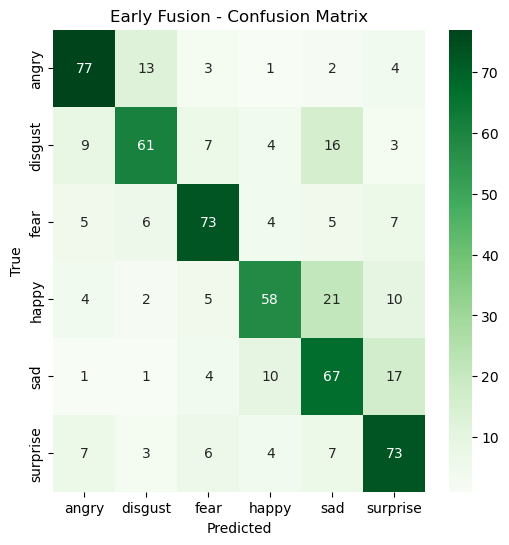

In [12]:
# Evaluate the Early Fusion model
y_early_pred_proba = early_fusion_model.predict([X_text_test, voice_test_embeddings])
y_early_pred = np.argmax(y_early_pred_proba, axis=1)

# Classification Report
print("\nEarly Fusion - Classification Report:\n")
print(classification_report(y_text_test, y_early_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_text_test, y_early_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap='Greens', 
    xticklabels=label_encoder.classes_, 
    yticklabels=label_encoder.classes_
)
plt.title('Early Fusion - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5291 - loss: 1.5701 - val_accuracy: 0.7433 - val_loss: 1.0728
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9761 - loss: 0.5582 - val_accuracy: 0.7433 - val_loss: 1.0405
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9736 - loss: 0.2617 - val_accuracy: 0.7433 - val_loss: 1.2287
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9736 - loss: 0.2100 - val_accuracy: 0.7433 - val_loss: 1.3354
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9761 - loss: 0.1926 - val_accuracy: 0.7433 - val_loss: 1.3984
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9710 - loss: 0.2095 - val_accuracy: 0.7433 - val_loss: 1.4390
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9775 - loss: 0.1758 - val_accuracy: 0.7433 - val_loss: 1.4453
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9742 - loss: 0.1774 - val_accuracy: 

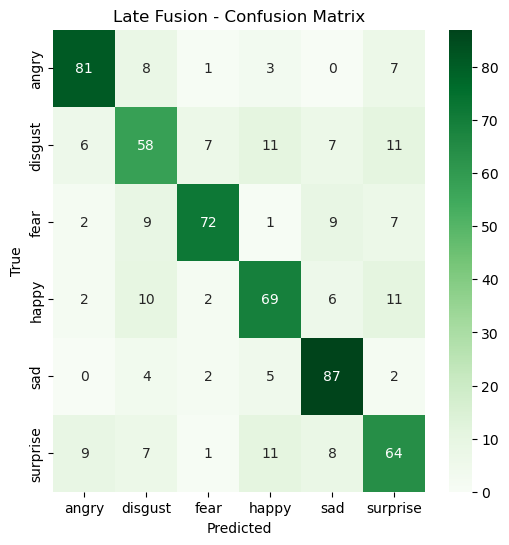

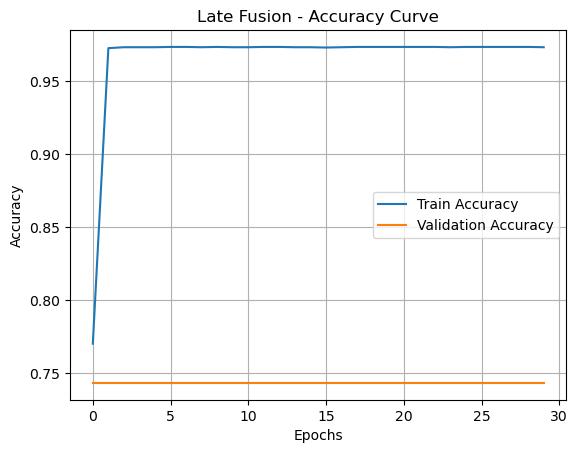

In [20]:
# Reshape the voice predictions to match the text predictions
# Assuming the voice model predictions are single values (class labels), we need to expand them to 2D (with the same number of columns as the number of classes).
voice_pred_train = np.expand_dims(voice_pred_train, axis=1)  # Shape: (batch_size, 1)
voice_pred_val = np.expand_dims(voice_pred_val, axis=1)      # Shape: (batch_size, 1)
voice_pred_test = np.expand_dims(voice_pred_test, axis=1)    # Shape: (batch_size, 1)

# Now, to match the shape of the text predictions (2D), one possible approach is to one-hot encode the voice predictions
from tensorflow.keras.utils import to_categorical

voice_pred_train_one_hot = to_categorical(voice_pred_train, num_classes=len(label_encoder.classes_))
voice_pred_val_one_hot = to_categorical(voice_pred_val, num_classes=len(label_encoder.classes_))
voice_pred_test_one_hot = to_categorical(voice_pred_test, num_classes=len(label_encoder.classes_))

# Flatten the one-hot encoded voice predictions to 2D arrays (batch_size, num_classes)
voice_pred_train_one_hot = np.reshape(voice_pred_train_one_hot, (voice_pred_train_one_hot.shape[0], -1))  # Shape: (batch_size, num_classes)
voice_pred_val_one_hot = np.reshape(voice_pred_val_one_hot, (voice_pred_val_one_hot.shape[0], -1))      # Shape: (batch_size, num_classes)
voice_pred_test_one_hot = np.reshape(voice_pred_test_one_hot, (voice_pred_test_one_hot.shape[0], -1))    # Shape: (batch_size, num_classes)

# Late fusion by combining text and voice predictions
late_fusion_train = np.concatenate([text_pred_train, voice_pred_train_one_hot], axis=1)
late_fusion_val = np.concatenate([text_pred_val, voice_pred_val_one_hot], axis=1)
late_fusion_test = np.concatenate([text_pred_test, voice_pred_test_one_hot], axis=1)

# Create a simple classifier to make final predictions based on the late-fused features
late_fusion_input = Input(shape=(late_fusion_train.shape[1],))  # Input size: sum of text + voice features
late_fusion_dense = Dense(64, activation='relu')(late_fusion_input)
late_fusion_dropout = Dropout(0.5)(late_fusion_dense)
late_fusion_output = Dense(6, activation='softmax')(late_fusion_dropout)

late_fusion_model = Model(inputs=late_fusion_input, outputs=late_fusion_output)
late_fusion_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the Late Fusion model
history_late = late_fusion_model.fit(
    late_fusion_train, y_text_train,
    validation_data=(late_fusion_val, y_text_val),
    epochs=30,
    batch_size=32
)

# Evaluate the Late Fusion model
y_late_pred_proba = late_fusion_model.predict(late_fusion_test)
y_late_pred = np.argmax(y_late_pred_proba, axis=1)

# Classification Report for Late Fusion
print("\nLate Fusion - Classification Report:\n")
print(classification_report(y_text_test, y_late_pred, target_names=label_encoder.classes_))

# Confusion Matrix for Late Fusion
cm = confusion_matrix(y_text_test, y_late_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Late Fusion - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Accuracy Curve for Late Fusion
plt.plot(history_late.history['accuracy'], label='Train Accuracy')
plt.plot(history_late.history['val_accuracy'], label='Validation Accuracy')
plt.title('Late Fusion - Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



E:\python\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 246ms/step - accuracy: 0.2867 - loss: 1.6582 - val_accuracy: 0.4583 - val_loss: 1.4498
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 252ms/step - accuracy: 0.5727 - loss: 1.1800 - val_accuracy: 0.6500 - val_loss: 1.1235
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 234ms/step - accuracy: 0.8205 - loss: 0.6120 - val_accuracy: 0.6750 - val_loss: 1.0641
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 251ms/step - accuracy: 0.9195 - loss: 0.3099 - val_accuracy: 0.6567 - val_loss: 1.1031
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 249ms/step - accuracy: 0.9530 - loss: 0.1980 - val_accuracy: 0.6700 - val_loss: 1.1521
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 242ms/step - accuracy: 0.9683 - loss: 0.1305 - val_accuracy: 0.6650 - val_loss: 1.2219
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 37s 244ms/step - accuracy: 0.9767 - loss: 0.1044 - val_accuracy: 0.6667 - val_loss: 1.3260
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 271ms/step - accuracy: 0.9761 - loss: 0

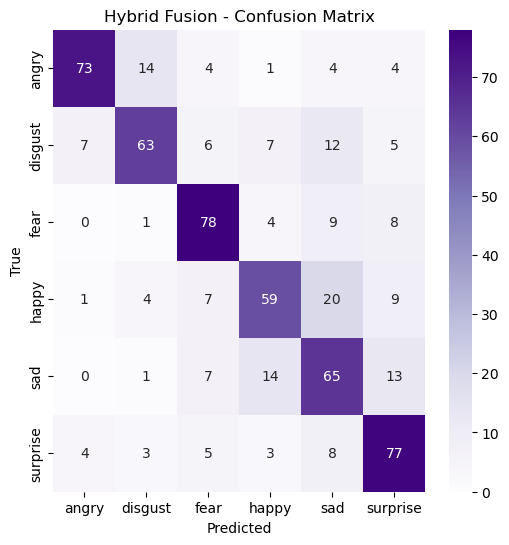

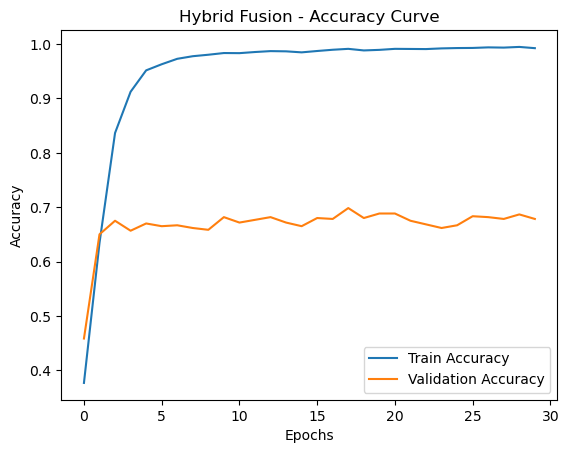

In [21]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model

# Reshape and preprocess the text data (Bi-LSTM embeddings)
input_text = Input(shape=(MAX_SEQ_LEN,), name='Text_Input')
text_embedding = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_length=MAX_SEQ_LEN)(input_text)
text_bilstm = Bidirectional(LSTM(128, dropout=0.5, return_sequences=False))(text_embedding)

# Reshape and preprocess the voice data (XGBoost embeddings)
voice_input = Input(shape=(1,), name='Voice_Input')  # Assuming voice model predictions are 1D (after XGBoost)

# Early Fusion: Concatenate text and voice embeddings
fusion = Concatenate()([text_bilstm, voice_input])

# Additional layers for hybrid processing
fusion_dense = Dense(64, activation='relu')(fusion)
fusion_dropout = Dropout(0.5)(fusion_dense)

# Final output layer (softmax for classification)
output = Dense(6, activation='softmax')(fusion_dropout)

# Create and compile the hybrid fusion model
hybrid_fusion_model = Model(inputs=[input_text, voice_input], outputs=output)
hybrid_fusion_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the Hybrid Fusion model
history_hybrid = hybrid_fusion_model.fit(
    [X_text_train, voice_train_embeddings], y_text_train,
    validation_data=([X_text_val, voice_val_embeddings], y_text_val),
    epochs=30,
    batch_size=32
)

# Evaluate the Hybrid Fusion model
y_hybrid_pred_proba = hybrid_fusion_model.predict([X_text_test, voice_test_embeddings])
y_hybrid_pred = np.argmax(y_hybrid_pred_proba, axis=1)

# Classification Report for Hybrid Fusion
print("\nHybrid Fusion - Classification Report:\n")
print(classification_report(y_text_test, y_hybrid_pred, target_names=label_encoder.classes_))

# Confusion Matrix for Hybrid Fusion
cm = confusion_matrix(y_text_test, y_hybrid_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Purples', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Hybrid Fusion - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Accuracy Curve for Hybrid Fusion
plt.plot(history_hybrid.history['accuracy'], label='Train Accuracy')
plt.plot(history_hybrid.history['val_accuracy'], label='Validation Accuracy')
plt.title('Hybrid Fusion - Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


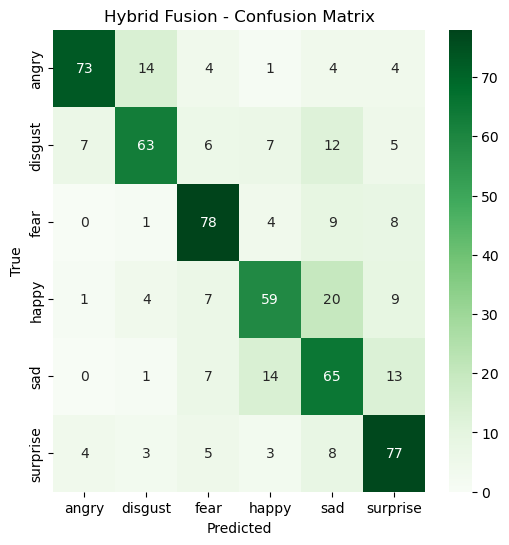

In [23]:
# Confusion Matrix for Hybrid Fusion
cm = confusion_matrix(y_text_test, y_hybrid_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Hybrid Fusion - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

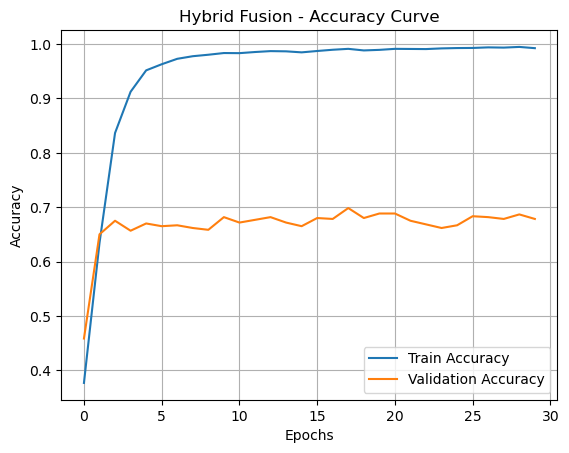

In [24]:
# Accuracy Curve for Hybrid Fusion
plt.plot(history_hybrid.history['accuracy'], label='Train Accuracy')
plt.plot(history_hybrid.history['val_accuracy'], label='Validation Accuracy')
plt.title('Hybrid Fusion - Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()